# Netflix Movie Recomendation System

Recommender systems typically fall into collaborative (CF) or content-based (CB) paradigms. Collaborative filtering predicts user preferences by leveraging patterns in many users’ past ratings, while content-based filtering recommends items similar to ones the user liked, based on item attributes like genre or keywords.  
  
We will build both types (and an optional hybrid) using Python libraries, and deploy a Streamlit app that fetches movie metadata (poster, overview, cast) via the TMDb API.

DataSet: https://grouplens.org/datasets/movielens/25m/

# Data Loading and Preprocessing

The MovieLens 25M dataset contains about 25,000,000 ratings by 162,541 users on 62,423 movies. We load the data with pandas and merge it into a single DataFrame

In [186]:
import pandas as pd

# Load Data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')
gnometags = pd.read_csv('genome-tags.csv')
gnomescore = pd.read_csv('genome-scores.csv')
tags = pd.read_csv('tags.csv') 

In [187]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [188]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [189]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [190]:
# Merge ratings with movie info
data = pd.merge(ratings, movies, on = 'movieId')

# Merge TMDb IDs for metadata lookup
data = pd.merge(data, links[['movieId', 'tmdbId']], on = 'movieId', how = 'left')

In [191]:
data.head()

,userId,movieId,rating,timestamp,title,genres,tmdbId
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0


In [192]:
data.dropna(inplace=True)

In [193]:
data['userId'] = data['userId'].astype(int)
data['movieId'] = data['movieId'].astype(int)
data['rating'] = data['rating'].astype(float)

In [194]:
data.head()

,userId,movieId,rating,timestamp,title,genres,tmdbId
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,680.0


# Exploratory Data Analysis (EDA)

In [195]:
n_users = data.userId.nunique()
n_movies = data.movieId.nunique()

In [196]:
print(n_movies, n_users)

58945 162541


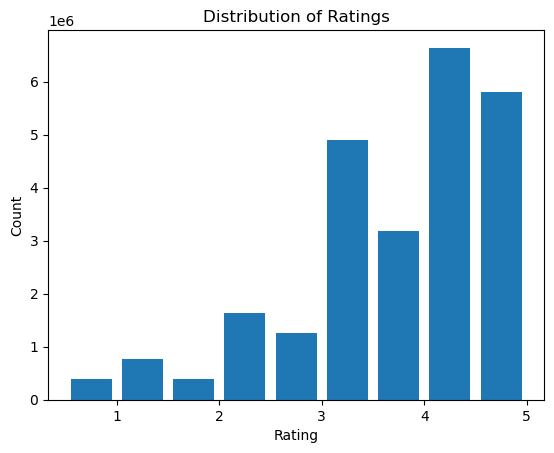

In [197]:
# Rating distribution
import matplotlib.pyplot as plt

plt.hist(data['rating'], bins = [i * 0.5 for i in range(1, 11)], rwidth = 0.8)
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Distribution of Ratings');
plt.show()

In [198]:
# Ratings per user/movie:

ratings_per_user = data.groupby('userId')['rating'].count()
ratings_per_movie = data.groupby('movieId')['rating'].count()
print(f'Avg ratings / user: {ratings_per_user.mean():.1f}')
print(f'Avg ratings / user: {ratings_per_movie.mean():.1f}')

Avg ratings / user: 153.8
Avg ratings / user: 424.1


# Feature Engineering

# Extract Release Year: 
We parse the year from the movie title (e.g. “Toy Story (1995)” → 1995) into a new column.

In [199]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)$')

In [200]:
movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


# One-Hot Encode Genres: 

The genres column lists pipe-separated genres (e.g. Action|Adventure|Sci-Fi). We create a binary column for each genre.

In [201]:
# Split genres and one-hot encode
genres_tags = movies.genres.str.get_dummies(sep = '|')
movies = pd.concat([movies, genres_tags], axis = 1)

In [202]:
movies

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,We (2018),Drama,2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62419,209159,Window of the Soul (2001),Documentary,2001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62420,209163,Bad Poems (2018),Comedy|Drama,2018,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
62421,209169,A Girl Thing (2001),(no genres listed),2001,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Aggregate Tags with TF–IDF
We merge tags.csv into movie data and combine all user-assigned tags per movie into one text.

In [203]:
tags['tag'] = tags['tag'].fillna('').astype(str)
tags_per_movie = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies = movies.merge(tags_per_movie, on = 'movieId', how = 'left').fillna({'tag':''})
movies['all_text'] = movies['tag'] + ' ' + movies['genres']

In [204]:
movies['all_text']

0        Owned imdb top 250 Pixar Pixar time travel chi...
1        Robin Williams time travel fantasy based on ch...
2        funny best friend duringcreditsstinger fishing...
3        based on novel or book chick flick divorce int...
4        aging baby confidence contraception daughter g...
                               ...                        
62418                                                Drama
62419                                          Documentary
62420                                         Comedy|Drama
62421                                   (no genres listed)
62422                               Action|Adventure|Drama
Name: all_text, Length: 62423, dtype: object

# Vectorise the text (tags + genres) with TF-IDF

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def normalize(text, use_stem = True):
    """
    Tokenize, lowercase, remove non-alpha & stopwords,
    then stem or lemmatize.
    """
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    
    if use_stem:
        return [stemmer.stem(t) for t in tokens]
    else:
        # pos='v' gets verbs, so 'adventuring'→'adventure'
        return [lemmatizer.lemmatize(t, pos = 'v') for t in tokens]

# 3. TF-IDF with our custom analyzer
tfid = TfidfVectorizer(
    analyzer = lambda doc: normalize(doc, use_stem = False),
    token_pattern = None,
    lowercase = False
)

tfidf_matrix = tfid.fit_transform(movies['all_text'])

# Extended Exploratory Data Analysis (EDA)

Rating Frequency Distribution  
We plot how many movies each user has rated. In a histogram we often see a long right tail: most users rate only a handful of movies, while a few power users rate thousands.

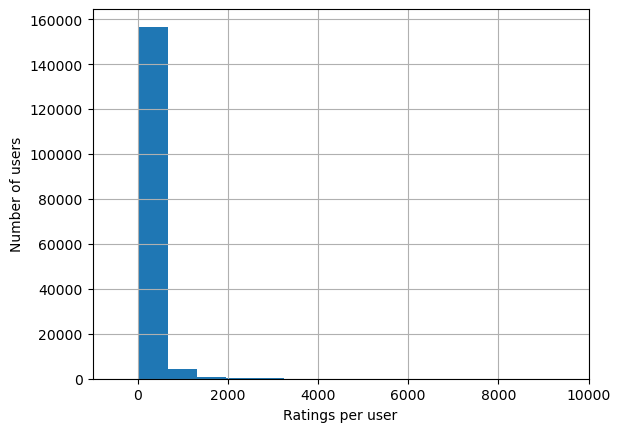

In [206]:
user_counts = ratings.groupby('userId').size()
user_counts.hist(bins = 50)
plt.xlabel('Ratings per user')
plt.ylabel('Number of users')
plt.xlim(-1000, 10000)
plt.show()

*Heavy concentration at the low end*    
The vast majority of users have rated only a handful of movies. You see the tallest bar way over on the left—hundreds of thousands of users with perhaps under 200 ratings each.  
  
*A long, thin tail of super-raters*  
A tiny slice of users are extremely active, rating hundreds or even thousands of movies. Those few outliers stretch the x-axis out toward 10,000 ratings.

*Temporal Trends*  
We examine how rating volume changes over time. Using the timestamp, we add a year/month column

<Axes: title={'center': 'Ratings per Year'}, xlabel='rating_data'>

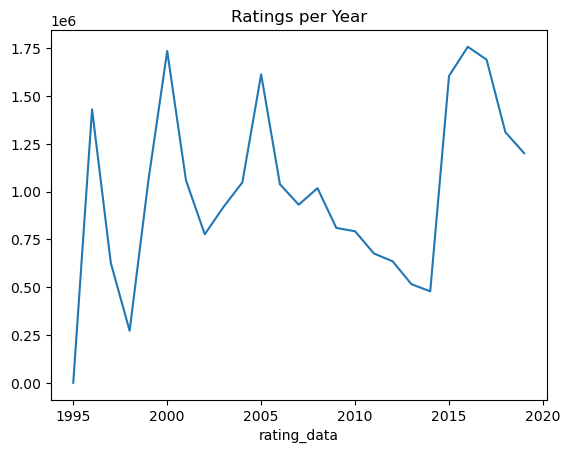

In [207]:
ratings['rating_data'] = pd.to_datetime(ratings.timestamp, unit = 's') # Since it is unix-time
ratings_by_year = ratings.groupby(ratings.rating_data.dt.year).size()
ratings_by_year.plot(title = 'Ratings per Year')

*Rating Heatmap (User vs. Popularity)*  
We can visualize rating density in relation to user activity and movie popularity. For instance, bucket users into deciles by number of ratings, and movies into deciles by total ratings, then plot a heatmap of count of ratings in each bin

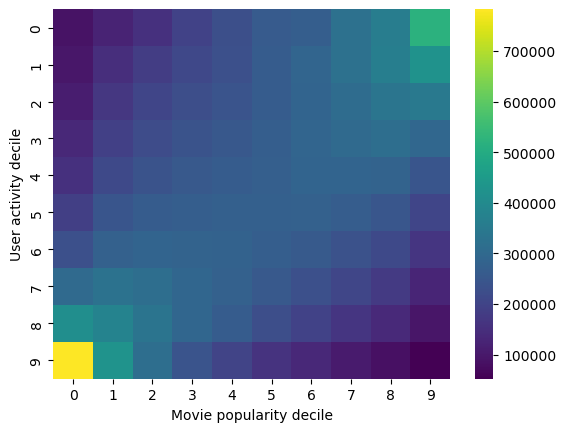

In [208]:
import seaborn as sns

user_bins = pd.qcut(ratings.groupby('userId')['rating'].transform('count'), 10, labels = False)
movie_bins = pd.qcut(ratings.groupby('movieId')['rating'].transform('count'),  10, labels = False)
heatmap_data = ratings.groupby([user_bins, movie_bins]).size().unstack(fill_value = 0)
sns.heatmap(heatmap_data, cmap = 'viridis')
plt.xlabel('Movie popularity decile')
plt.ylabel('User activity decile')
plt.show()

# User‐Level Statistics

*rating_count:* total number of ratings they’ve given  

*rating_mean:* their average rating  

*rating_var:* variance of their ratings 

*user_std:* how consistent the user is (lower std = more stable preferences) 

*last_rating_ts:* timestamp of their most recent rating  

In [209]:
# Compute per-user stats
user_feats = ratings.groupby('userId').agg(
    user_rating_count = ('rating', 'count'),
    user_rating_mean = ('rating', 'mean'),
    user_rating_var = ('rating', 'var'),
    user_rating_std = ('rating', 'std'),
    user_last_rating_ts = ('timestamp', 'max')
).reset_index()

user_feats['user_rating_std'] = user_feats['user_rating_std'].fillna(0)

user_feats['user_last_rating_ts'] = pd.to_datetime(user_feats['user_last_rating_ts'], unit='s')

user_feats['user_last_rating_ordinal'] = user_feats['user_last_rating_ts'].map(lambda x: x.toordinal())

user_feats.head()

,userId,user_rating_count,user_rating_mean,user_rating_var,user_rating_std,user_last_rating_ts,user_last_rating_ordinal
0,1,70,3.814286,1.008489,1.004235,2006-05-17 15:34:15,732448
1,2,184,3.630435,2.124970,1.457728,2006-03-03 20:33:28,732373
2,3,656,3.697409,0.359825,0.599854,2019-08-18 01:31:23,737289
3,4,242,3.378099,1.247527,1.116927,2019-11-19 20:25:01,737382
4,5,101,3.752475,0.868119,0.931729,1997-03-17 19:53:41,729100


# movie‐level features stats  
*rating_count:* number of ratings each movie has received  

*rating_mean:* its average rating  

*rating_var:* variance in its ratings  

*release_year:* already extracted from titles  

*genre one-hot columns:* pulled straight from your movies DF  

In [210]:
# Movie-level rating stats
movie_stats = ratings.groupby('movieId').agg(
    movie_rating_count = ('rating', 'count'),
    movie_rating_mean = ('rating', 'mean'),
    movie_rating_var = ('rating', 'var'),
    movie_rating_std = ('rating', 'std')
).reset_index()

if '(no genres listed)' in movies.columns:
    movies.drop(columns=['(no genres listed)'], inplace=True)

# Pull in release year & genres
# 'movies' already has 'year' and one-hot genre columns
genre_cols = [c for c in movies.columns if c not in ['movieId','title','genres','tags','all_text','year']]

movie_feats = movie_stats.merge(
    movies[['movieId', 'year'] + genre_cols],
    on = 'movieId', how = 'left'
)

# Fill NaNs in variance (e.g. movies with a single rating)
movie_feats['movie_rating_var'] = movie_feats['movie_rating_var'].fillna(0)

movie_feats.head()

,movieId,movie_rating_count,movie_rating_mean,movie_rating_var,movie_rating_std,year,Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag
0,1,57309,3.893708,0.849258,0.921552,1995,0,1,1,1,...,0,0,0,0,0,0,0,0,0,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,24228,3.251527,0.921315,0.959851,1995,0,1,0,1,...,0,0,0,0,0,0,0,0,0,Robin Williams time travel fantasy based on ch...
2,3,11804,3.142028,1.016957,1.008443,1995,0,0,0,0,...,0,0,0,0,1,0,0,0,0,funny best friend duringcreditsstinger fishing...
3,4,2523,2.853547,1.228841,1.108531,1995,0,0,0,0,...,0,0,0,0,1,0,0,0,0,based on novel or book chick flick divorce int...
4,5,11714,3.058434,0.993234,0.996611,1995,0,0,0,0,...,0,0,0,0,0,0,0,0,0,aging baby confidence contraception daughter g...


# User-level Features Merge with movie_feats

merge all of this into a single dataset that can be used for clustering, training models, or export

In [222]:
# Merge all features
movie_rating = ratings.merge(movie_feats, on = 'movieId', how = 'left')\
        .merge(user_feats, on = 'userId', how = 'left')

# Drop unnecessary columns
movie_rating.drop(columns = ['timestamp', 'rating_data', 'tag'], inplace = True, errors = 'ignore')

# Drop duplicates if any
movie_rating.drop_duplicates(inplace = True)

# Fill NaNs
movie_rating.fillna(0, inplace = True)

print(movie_rating.shape)
movie_rating.head()

(25000095, 33)


,userId,movieId,rating,movie_rating_count,movie_rating_mean,movie_rating_var,movie_rating_std,year,Action,Adventure,...,Sci-Fi,Thriller,War,Western,user_rating_count,user_rating_mean,user_rating_var,user_rating_std,user_last_rating_ts,user_last_rating_ordinal
0,1,296,5.0,79672,4.188912,0.919371,0.958838,1994,0,0,...,0,1,0,0,70,3.814286,1.008489,1.004235,2006-05-17 15:34:15,732448
1,1,306,3.5,7058,4.072967,0.866788,0.931014,1994,0,0,...,0,0,0,0,70,3.814286,1.008489,1.004235,2006-05-17 15:34:15,732448
2,1,307,5.0,6616,3.981409,0.900335,0.948860,1993,0,0,...,0,0,0,0,70,3.814286,1.008489,1.004235,2006-05-17 15:34:15,732448
3,1,665,5.0,1269,3.946020,1.040656,1.020126,1995,0,0,...,0,0,1,0,70,3.814286,1.008489,1.004235,2006-05-17 15:34:15,732448
4,1,899,3.5,10895,4.050987,0.946432,0.972847,1952,0,0,...,0,0,0,0,70,3.814286,1.008489,1.004235,2006-05-17 15:34:15,732448


#  Train-Test Split and Export  

Since our goal is both rating prediction and recommendation, it’s best to:  

Split by timestamp (simulate real-world: train on past, predict on future).  

Maintain full user/movie profiles for inference (avoid cold-starts).  



In [225]:
from sklearn.model_selection import train_test_split

# Sort by timestamp to simulate real-world usage (older = train, newer = test)
movie_rating.sort_values(by = 'user_last_rating_ordinal',inplace = True)

# 80-20 Split
train_df, test_df = train_test_split(movie_rating, test_size = 0.2, shuffle = False)

# Export
train_df.to_csv('training/train.csv'); test_df.to_csv('training/test.csv');